In [1]:
import h3
import pandas as pd
from glob import glob
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np

TIME_DELTA = pd.Timedelta(1, 'days')
RING_SIZE = 7

p = os.path.join

sns.set()
sns.set_context('poster')

cities = os.listdir(p('..', '01 Pollution Data'))

# Loads Y Data

In [2]:
def load_y_data(city):
    df = pd.read_csv(p('..', '01 Pollution Data', city, 'y_data.csv'), index_col=[1], parse_dates=[1])
    df = df.groupby('h3id').resample(TIME_DELTA).mean()
    df['city'] = city
    return df
y_real = pd.concat([load_y_data(c) for c in cities])

# Load X Data

In [3]:
X = pd.concat([pd.read_csv(f) for f in glob(p('..','Waze Data','chunks','*.csv'))])
X['time'] = pd.to_datetime(X[['day', 'month', 'year']])
X = X.groupby('h3id').resample(TIME_DELTA, on='time').mean()
X = X.drop(['day', 'month', 'year'], axis=1)

In [4]:
def using_mean(tup):
    (h3id, timestamp) = tup
    ring = h3.k_ring(h3id, 1)
    idx = [(r, timestamp) for r in ring]
    neighborhood = X.reindex(idx)
    
    final = neighborhood.mean()
    final['bool_highway'] = neighborhood.bool_highway.max()
    final['bool_ramps'] = neighborhood.bool_ramps.max()
    return final

X_mean = pd.DataFrame([using_mean(idx) for idx in X.index])
X_mean.index = X.index

## Linear Regression

In [6]:
models = p('..','00 Models', 'models.p')
updated_models = pickle.load(open(models, "rb"))

param_norm = p('..','00 Models', 'data.p')
norm = pickle.load(open(param_norm, "rb"))

In [7]:
dfTemp = pd.DataFrame(columns=X_mean.columns)
dfTemp.loc[0] = norm[1][1]['model_data']['scaler-data_min_']
dfTemp.loc[1] =norm[1][1]['model_data']['scaler-data_max_']

# Create MaxMin scaler
scaler = MinMaxScaler()
scaler.fit(dfTemp)
X_scaled = pd.DataFrame(scaler.transform(X_mean))
X_scaled.columns = X_mean.columns
X_scaled.index = X_mean.index

y_hat = pd.DataFrame(updated_models['NO2'].predict(X_scaled))
y_hat.index = X_scaled.index

In [9]:
def adapt_linear(city, y_original, y_pred):
    linear = LinearRegression()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))
    fig.suptitle(city)
    
    y_shaped = y_pred.values.reshape(-1, 1)
    fitted = linear.fit(y_shaped, y_original)
    y_fitted = fitted.predict(y_shaped)
    diag = [y_original.min(), y_original.max()]
    
    sns.scatterplot(x=y_original, y=y_fitted, color="C1", ax=ax1)
    ax1.plot(diag, diag,'--', c='black', alpha=0.25, label="Main Diagonal")
    ax1.legend([],[], frameon=False)
    ax1.set_title('Adapted')
    ax1.axis('equal')
    
    sns.scatterplot(x=y_original, y=y_pred.values, label="Without adapting", ax=ax2)
    ax2.plot(diag, diag,'--', c='black', alpha=0.25, label="Main Diagonal")
    ax2.legend([],[], frameon=False)
    ax2.set_title("Without adapting")
    ax2.axis('equal')
    
    
    plt.xlabel("Original")
    plt.ylabel("Predito")
    
    return fitted

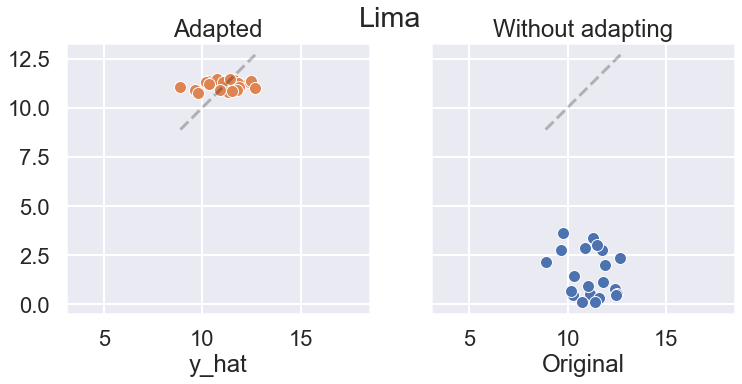

In [10]:
linear_regs= {}
for (c, y_real_city) in y_real.groupby('city'):
    idx = y_real_city.index
    y_hat_city = y_hat.reindex(y_real_city.index)
    both_contain = pd.concat([y_hat_city, y_real_city.NO2], axis=1).dropna()
    both_contain.columns = ["y_hat", 'y_real']
    if(len(both_contain)):
        lin = adapt_linear(c, both_contain.y_hat, both_contain.y_real)
        linear_regs[c] = lin

# Generating final csv with predictions

This is the step where we take all of the data from Waze and predict the NO2 values

In [13]:
y_hat.columns = ['NO2_pred']
station_ids = y_real.index.get_level_values('h3id').unique()
city_dict = {}
for s_id in station_ids:
    city = y_real.xs('898e62c044bffff', level='h3id').city[0]
    city_dict[s_id] = city
    ring = h3.k_ring(s_id, RING_SIZE)
    for r in ring:
        city_dict[r] = city

In [14]:
final = y_hat.copy()
final['NO2'] = y_real.NO2
final['city'] = final.apply(lambda row: city_dict[row.name[0]], axis=1)
final['NO2_adjusted'] = final.apply(lambda row: linear_regs[row.city].predict(np.array(row['NO2_pred']).reshape(-1, 1))[0], axis=1)
final[['city', 'NO2', 'NO2_pred', 'NO2_adjusted']].to_csv('final_prediction.csv')